# Setup

In [2]:

# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [1]:

# use numpy compatible with mirdata
!pip install numpy==1.25.0


In [6]:

# cd into SipSync folder
# (replace with correct path for you)
%cd /content/drive/MyDrive/DL4M/SipSync


/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync


In [3]:

# install other dependencies
%pip install mirdata keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.6/260.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:

# Automatically upload files with each change
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:

#import dependencies
import warnings
import tensorflow as tf
import keras
from numpy.random import seed
import sys
import os
import mirdata
import utils as u
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from models import tcn_model
import IPython

# Fix the random seed for reproducibility
seed(124)
tf.keras.utils.set_random_seed(124)

# Append the directory containing utils1.py to the system path
sys.path.append('/content/drive/MyDrive/DL4M/SipSync')



# Load Data

In [10]:

# initialize mirdata and download dataset
data_home = '/content/drive/MyDrive/DL4M/SipSync/mir_datasets/'
dataset = mirdata.initialize('mtg_jamendo_autotagging_moodtheme', data_home=data_home)
dataset.download(cleanup=True, force_overwrite=True)


33.3MB [00:05, 6.57MB/s]                            
2.30MB [00:02, 1.17MB/s]                            


In [11]:

# filter for only tracks we were able to download
available_tracks = {}

for track_id, track in dataset.load_tracks().items():
    if os.path.exists(track.audio_path):
        available_tracks[track_id] = track

print(f"Found {len(available_tracks)} available tracks with audio.")


Found 3125 available tracks with audio.


In [12]:
# The only emotional tags we're using
selected_tags = ['mood/theme---happy', 'mood/theme---positive', 'mood/theme---love', 'mood/theme---romantic', 'mood/theme---energetic', 'mood/theme---party', 'mood/theme---relaxing', 'mood/theme---calm', 'mood/theme---sad', 'mood/theme---melancholic']


# Filter to only available tracks (those with an existing audio file with a selected tag)
available_tracks = {
    track_id: track for track_id, track in dataset.load_tracks().items()
    if os.path.exists(track.audio_path)
    and track.tags in selected_tags
}

# Choose a random song from the available tracks
if available_tracks:
    track_id = random.choice(list(available_tracks.keys()))
    track = available_tracks[track_id]

    print("Track ID:", track_id)
    print("Audio path:", track.audio_path)
    print("Audio tuple (waveform, sr):", track.audio)

else:
    print("No available audio files found.")



Track ID: track_1087109
Audio path: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/09/1087109.mp3
Audio tuple (waveform, sr): (array([ 0.00946461, -0.06171178, -0.1684516 , ..., -0.14889388,
       -0.1816803 , -0.1659464 ], dtype=float32), 22050)


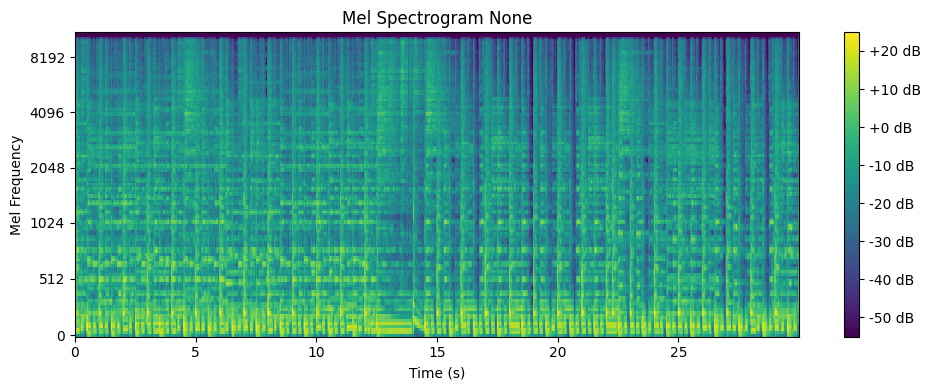

In [13]:
# display mel spectrogram and play audio to make sure data is properly loaded

n_mels = 128
hop_size = 512
spectrogram = u.compute_mel_spectrogram(track.audio[0], track.audio[1], n_mels, hop_size)

u.plot_spectrogram(spectrogram, track.audio[1], hop_size)

IPython.display.Audio(track.audio[0], rate=track.audio[1])


In [14]:

# Split tracks into training, testing, and validation

track_ids = list(available_tracks.keys())

train_ids, test_ids = train_test_split(track_ids, test_size=0.2, random_state=124)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=124)

print(f"Number of Tracks in Training Set: {len(train_ids)}")
print(f"Number of Tracks in Validation Set: {len(val_ids)}")
print(f"Number of Tracks in Test Set: {len(test_ids)}")


Number of Tracks in Training Set: 441
Number of Tracks in Validation Set: 147
Number of Tracks in Test Set: 148


In [15]:

# get labels for each datapoint in each set

def get_main_tag(tag_string):
    return tag_string.split(",")[0] if tag_string else "unknown"

split_data = dataset.get_track_splits(split_number=0)

labels_train = [get_main_tag(dataset.track(tid).tags) for tid in split_data['train'] if tid in available_tracks.keys()]
labels_val = [get_main_tag(dataset.track(tid).tags) for tid in split_data['validation'] if tid in available_tracks.keys()]
labels_test = [get_main_tag(dataset.track(tid).tags) for tid in split_data['test'] if tid in available_tracks.keys()]


In [16]:

# ensure each mood is represented in each dataset
print('Number of classes in each dataset')
print(f'Train set: {len(set(labels_train))}')
print(f'Validation set: {len(set(labels_val))}')
print(f'Test set: {len(set(labels_test))}')

# dictionary to map moods to class values
mood_mapping = {mood: i for i, mood in enumerate(selected_tags)}
moods = mood_mapping.keys()
print('\nMood mapping')
mood_mapping


Number of classes in each dataset
Train set: 10
Validation set: 10
Test set: 10

Mood mapping


{'mood/theme---happy': 0,
 'mood/theme---positive': 1,
 'mood/theme---love': 2,
 'mood/theme---romantic': 3,
 'mood/theme---energetic': 4,
 'mood/theme---party': 5,
 'mood/theme---relaxing': 6,
 'mood/theme---calm': 7,
 'mood/theme---sad': 8,
 'mood/theme---melancholic': 9}

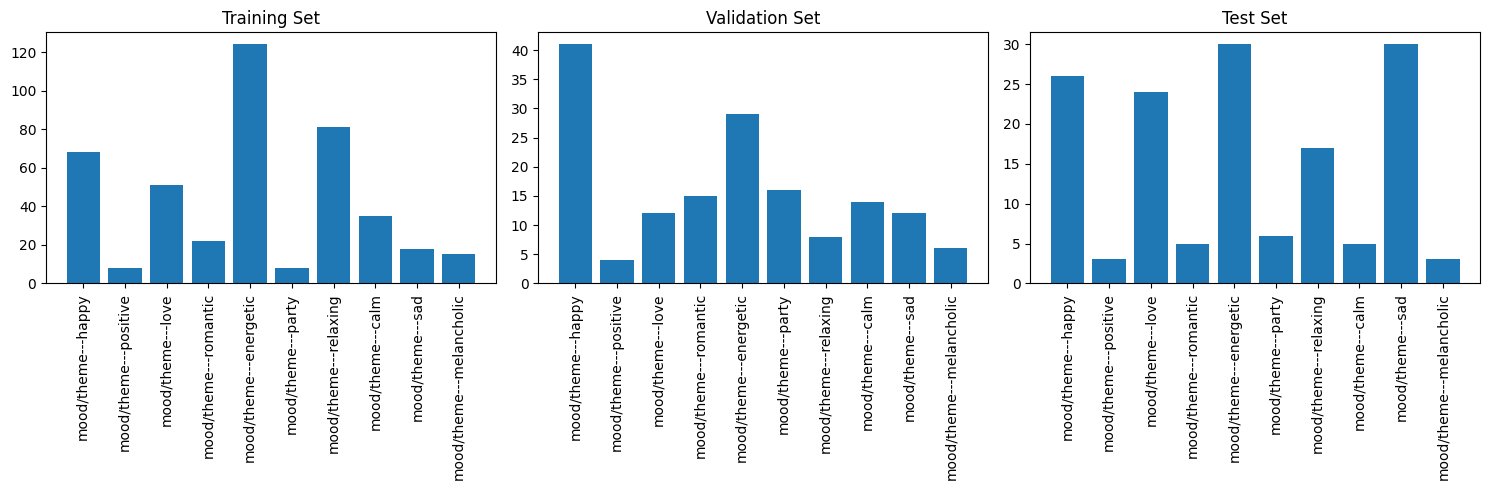

In [17]:

# explore data
u.explore_data_mood(labels_train, labels_val, labels_test, mood_mapping)


In [18]:

# create class weights
mood_weights ={}

for mood in mood_mapping.keys():
  try:
    mood_weights[mood_mapping[mood]] = 1/labels_train.count(mood)
  except:
    mood_weights[mood_mapping[mood]] = 0

mood_weights


{0: 0.014705882352941176,
 1: 0.125,
 2: 0.0196078431372549,
 3: 0.045454545454545456,
 4: 0.008064516129032258,
 5: 0.125,
 6: 0.012345679012345678,
 7: 0.02857142857142857,
 8: 0.05555555555555555,
 9: 0.06666666666666667}

# YAMnet transfer learn

In [19]:

# Prep data for YAMnet

sample_rate = 16000  # 16kHz for YAMNet
augment = False
input_shape = (29*sample_rate,)

input_args_train = [data_home, augment, train_ids, sample_rate]
input_args_val   = [data_home, augment, val_ids, sample_rate]
input_args_test  = [data_home, augment, test_ids, sample_rate]

dataset_train = u.create_dataset(u.wav_generator, input_args_train, input_shape)
dataset_val = u.create_dataset(u.wav_generator, input_args_val, input_shape)
dataset_test= u.create_dataset(u.wav_generator, input_args_test, input_shape)


In [20]:

# load yamnet
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')


In [21]:

input_shape =  (60, 1024)
# Create a tcn model that processes the embeddings
tcn_yamnet = tcn_model(input_shape)

# Print model summary
tcn_yamnet.summary()


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       619,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,978 (2.37 MB)

 Trainable params: 619,978 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# Define a mapping function to extract embeddings
def map_function(audio, label):
   return u.extract_yamnet_embedding(audio, yamnet), label

# Check input shape from example in the data
for e, l in dataset_train.map(map_function).take(1):
    print(e.shape)


(60, 1024)


In [23]:

# Train model

batch_size = 32
model_path = "checkpoints/yamnet_model.json"
model_weights = "checkpoints/yamnet.weights.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=model_weights,
      save_best_only=True,
      save_weights_only=True,
      monitor="val_loss")
]

history = tcn_yamnet.fit(dataset_train.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    validation_data=dataset_val.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    epochs=10,
    class_weight=mood_weights,
    callbacks=callbacks)

model_as_json = tcn_yamnet.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_as_json)


Epoch 1/10
     14/Unknown 1042s 74s/step - accuracy: 0.1274 - loss: 0.0688

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1407s 102s/step - accuracy: 0.1283 - loss: 0.0686 - val_accuracy: 0.1224 - val_loss: 2.3470
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1946 - loss: 0.0462 - val_accuracy: 0.1701 - val_loss: 2.2370
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3992 - loss: 0.0343 - val_accuracy: 0.2653 - val_loss: 2.2881
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5658 - loss: 0.0250 - val_accuracy: 0.2517 - val_loss: 2.3498
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6692 - loss: 0.0185 - val_accuracy: 0.2245 - val_loss: 3.0661
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7231 - loss: 0.0159 - val_accuracy: 0.2925 - val_loss: 2.4478
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8566 - loss: 0.0099 - val_accuracy: 0.3129 - val_loss: 2.4876
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8854 - loss: 0.0079 - val_accuracy: 0.3061 - val_loss: 

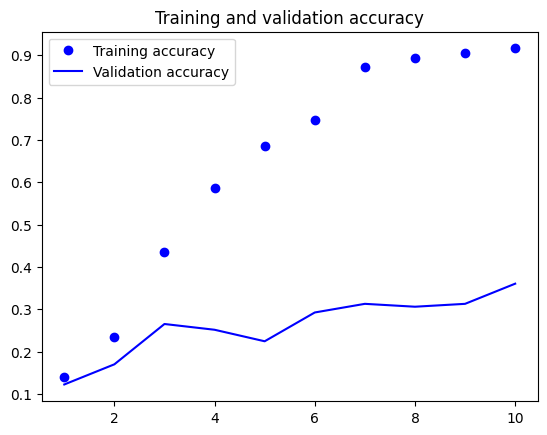

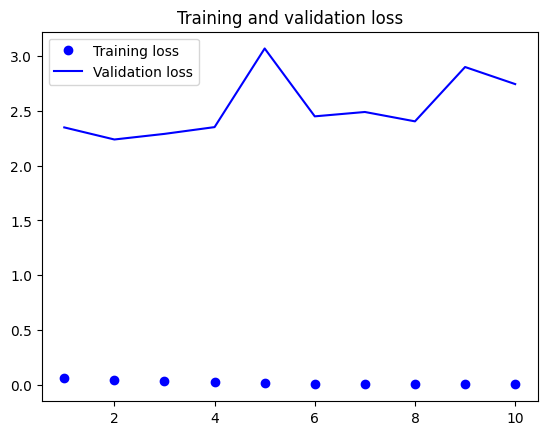

In [24]:

# Plot history
u.plot_loss(history)


In [25]:

# Load the best checkpoint of the model
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
metrics = ["accuracy"]
tcn_yamnet_reloaded = u.reload_tcn(model_path, model_weights, optimizer, loss, metrics)

# Evaluate the model on the test set
test_loss_yamnet, test_acc_yamnet = tcn_yamnet_reloaded.evaluate(dataset_test.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size))
print(f"Test Loss: {test_loss_yamnet:.4f}, Test Accuracy: {test_acc_yamnet:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 368s 68s/step - accuracy: 0.1574 - loss: 2.2696
Test Loss: 2.2271, Test Accuracy: 0.1689
